# 简介

本实验将使用Pytorch实现word2vec的SkipGram模型，并采用了Negative Sampling的策略，同时使用了来自语料库的Penn Tree Bank的数据集`PTB.train.txt`对模型进行训练，得到了词向量。

# 数据处理与下载

因为本实验是在Google Colab上进行的，所以需要先挂在Google的drive。

In [59]:
import os
from google.colab import drive
drive.mount("/content/drive")
path = "/content/drive/My Drive"
os.chdir(path)
!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 2238322.gdoc	   'Modern Family s01e01 Episode Script | SS.gdoc'
 2238322.pdf	   'Modern Family s01e01 Episode Script | SS.pdf'
'Colab Notebooks'   ptb.train.txt
 fractal.mp4	    WechatIMG7.jpeg


由上我们可以看到，此时我们已经切换到了所需训练文件所在的路径了。

我们可以先读取部分的数据，并观察一下数据。

In [60]:
with open("ptb.train.txt", encoding="utf-8") as f:
    lines = f.readlines()
print(f"The number of lines in the dataset is {len(lines)}.")

The number of lines in the dataset is 42068.


我们可以看到数据集由4万多条文本组成。

现在我们对利用空格进行粗分词，并对文本前三行进行次数的统计和前6个词语的显示。

In [61]:
datasets = [line.split() for line in lines]
for i in range(3):
    print(f"The number of word in the {i+1} line is {len(datasets[i])}.")
    print(f"The first 6 word in the {i+1} line is {datasets[i][:6]}")
    print()

The number of word in the 1 line is 24.
The first 6 word in the 1 line is ['aer', 'banknote', 'berlitz', 'calloway', 'centrust', 'cluett']

The number of word in the 2 line is 15.
The first 6 word in the 2 line is ['pierre', '<unk>', 'N', 'years', 'old', 'will']

The number of word in the 3 line is 11.
The first 6 word in the 3 line is ['mr.', '<unk>', 'is', 'chairman', 'of', '<unk>']



我们可以看到数据集中数字都被转换为'N'表示，生僻词都转换为'`<unk>`'表示。

由此我们得到了模型训练所需要的数据集`datasets`了。

# 词语索引建立

只有文本数据是没有用的，我们需要做的是对数据集进行词频的统计，为了训练的计算简单，把词频低于5的词语丢弃，同时建立词语和索引之间的互相映射。

In [0]:
from collections import Counter

counter = Counter([word for line in datasets for word in line])
counter = dict(filter(lambda x: x[1] > 5, counter.items()))

In [63]:
print(f"The number of word in the vocabulary is {len(counter)}.")

The number of word in the vocabulary is 9582.


建立词语和索引之间的互相映射。

In [64]:
idx_to_word = [word for word, _ in counter.items()]
word_to_idx = {word: idx for idx, word in enumerate(idx_to_word)}
index = word_to_idx['car']
print(f"The index of car is {index}.")
print(f"The word of index {index} is {idx_to_word[index]}.")

The index of car is 3786.
The word of index 3786 is car.


将`datasets`里的所有word转换为index：

In [0]:
datasets = [[word_to_idx[word] for word in line if word in word_to_idx] for line in datasets]

In [0]:
num_tokens = sum([len(line) for line in datasets])

# 二次采样

文本中会有很多的高频词，譬如：`the`等，这些高频词对于词向量的构建来说相较于低频词`join`等的重要性要低，所以我们要根据词频进行二次采样，以一定的概率丢掉部分的高频词，概率计算公式如下：
$$
P(w_i)=\max\left(1-\sqrt{\frac{t}{f(w_i)}},0\right),
$$
其中$f(w_i)$表示的是词$w_i$的词频，$t$为超参数，这里设为$10^{-4}$。

In [0]:
import random
import math

def throw(idx):
    return random.uniform(0, 1) < (1 - math.sqrt(1e-4 / counter[idx_to_word[idx]] * num_tokens))

subsampling = [[idx for idx in line if not throw(idx)] for line in datasets]

由此我们得到二次采样后的新数据集，我们可以比较一下新数据集与原数据集的差别。

In [68]:
print(f"The number of words in subsampling dataset is {sum([len(line) for line in subsampling])}.")
print(f"The number of words in original dataset is {sum([len(line) for line in datasets])}.")

The number of words in subsampling dataset is 373692.
The number of words in original dataset is 885720.


我们也可以看一下高频词`the`的频数的变化：

In [69]:
before_the_num = sum([line.count(word_to_idx['the']) for line in datasets])
after_the_num = sum([line.count(word_to_idx['the']) for line in subsampling])
print(f"Before subsampling, the frequency of 'the' is {before_the_num}.")
print(f"After subsampling, the frequency of 'the' is {after_the_num}.")

Before subsampling, the frequency of 'the' is 50770.
After subsampling, the frequency of 'the' is 2091.


我们也可以看一下低频词`car`的频数的变化：

In [98]:
before_car_num = sum([line.count(word_to_idx['car']) for line in datasets])
after_car_num = sum([line.count(word_to_idx['car']) for line in subsampling])
print(f"Before subsampling, the frequency of 'car' is {before_car_num}.")
print(f"After subsampling, the frequency of 'car' is {after_car_num}.")

Before subsampling, the frequency of 'car' is 182.
After subsampling, the frequency of 'car' is 132.


我们可以看到低频词的频数的变化远小于高频词的频数变化，这符合我们的预期，接下来我们将在subsampling数据集进行处理。

# 提取center word与context word

对于每一个center word，我们随机在1到`max_window_size`选一个整数作为context窗口的大小。

In [0]:
def get_centers_and_contexts(datasets, max_window_size=4):
    centers, contexts = [], []
    for line in datasets:
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size), min(len(line), i + window_size + 1)))
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

函数测试：

In [72]:
toy_data = [list(range(8)), [8, 9, 10]]
toy_centers, toy_contexts = get_centers_and_contexts(toy_data, 2)
for cen, cont in zip(toy_centers, toy_contexts):
    print(f"Center word: {cen} -> Context words: {cont}.")

Center word: 0 -> Context words: [1].
Center word: 1 -> Context words: [0, 2, 3].
Center word: 2 -> Context words: [1, 3].
Center word: 3 -> Context words: [2, 4].
Center word: 4 -> Context words: [2, 3, 5, 6].
Center word: 5 -> Context words: [3, 4, 6, 7].
Center word: 6 -> Context words: [4, 5, 7].
Center word: 7 -> Context words: [5, 6].
Center word: 8 -> Context words: [9, 10].
Center word: 9 -> Context words: [8, 10].
Center word: 10 -> Context words: [9].


接下来我们要提取数据集的所有center word和context words：

In [0]:
all_centers, all_contexts = get_centers_and_contexts(subsampling, 5)

# 负采样

对于一对的center word和context word，我们要提取$K$个noise word，这里$K$取5，以词频的0.75次方概率从词典中取词。

In [0]:
def get_negatives(all_contexts, K, sampling_weights):
    i = 0
    all_negatives = []
    negatives_candidate = []
    population = list(range(len(sampling_weights)))
    for context in all_contexts:
        negatives = []
        while len(negatives) < len(context) * K:
            if i == len(negatives_candidate):
                negatives_candidate = random.choices(population, sampling_weights, k=int(1e5))
                i = 0
            neg, i = negatives_candidate[i], i+1
            if neg not in set(context):
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives

In [0]:
sampling_weights = [counter[word] ** 0.75 for word in word_to_idx]
all_negatives = get_negatives(all_contexts, 5, sampling_weights)

# 数据读取

在获得了对应的`all_centers`，`all_contexts`和`all_negatives`之后，我们要批量读取数据。

In [0]:
import torch
import torch.nn as nn

class MyDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives
    
    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index], self.negatives[index])
    
    def __len__(self):
        return len(self.centers)

一个小批量的数据会包含center word以及它的context和negative，这里我们打算把context和negative合并在一起为一个序列，但因为每个center word对应的context，negative pair的长度都是不一样，这时需要给每个序列补长，使他们达到相同的长度，这里直接补0就可以了，但这里要注意的是损失函数计算的时候，这些补充的元素并不参与计算，所以要给每个元素增添上一个mask，如果该word是补码的话，就为0，不是的话，就为1，因为我们把context和negative和在一起了，我们也需要一个label vector，用来标记哪个是正例，用1标记context，其他为0。

In [0]:
def batchify(data):
    max_len = max([len(context) + len(neg) for _, context, neg in data])
    centers = []
    contexts_negatives = []
    masks = []
    labels = []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        contexts_negatives.append(context + negative + [0] * (max_len - cur_len))
        centers.append(center)
        masks.append([1] * cur_len + [0] * (max_len - cur_len))
        labels.append([1] * len(context) + [0] * (max_len - len(context)))
    return (torch.tensor(centers).view(-1, 1), torch.tensor(contexts_negatives),
            torch.tensor(masks), torch.tensor(labels))

利用DataLoader批量读取数据：

In [78]:
batch_size = 512
data = MyDataset(all_centers, all_contexts, all_negatives)
data_iter = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True,
                                        collate_fn=batchify)
for batch in data_iter:
    for name, data in zip(["centers", "context_negatives", "masks", "labels"], batch):
        print(f"{name} word shape: {data.shape}")
    break

centers word shape: torch.Size([512, 1])
context_negatives word shape: torch.Size([512, 60])
masks word shape: torch.Size([512, 60])
labels word shape: torch.Size([512, 60])


# SkipGram模型前向传播

In [0]:
def skipGram(center, context_negative, embed_v, embed_u):
    v = embed_v(center) # [batch_size, embed_size]
    u = embed_u(context_negative) # [batch_size, seq_len, embed_size]
    pred = torch.bmm(v, u.permute(0, 2, 1)) # [batch_size, 1, seq_len]
    return pred

Loss function：

In [0]:
class CrossEntropyLoss(nn.Module):
    def __init__(self):
        super(CrossEntropyLoss, self).__init__()
    
    def forward(self, pred, labels, mask=None):
        pred = pred.float()
        labels = labels.float()
        mask = mask.float()
        loss = nn.functional.binary_cross_entropy_with_logits(pred, labels, weight=mask,
                                                              reduction='none')
        return loss.mean(dim=1)
    
Loss = CrossEntropyLoss()

In [81]:
pred = torch.tensor([[1.5, 0.3, -1, 2], [1.1, -0.6, 2.2, 0.4]]).float()
label = torch.tensor([[1, 0, 0, 0], [1, 1, 0, 0]]).float()
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 1, 0]]).float()
loss = nn.functional.binary_cross_entropy_with_logits(pred, label, weight=mask, reduction='none')
loss

tensor([[0.2014, 0.8544, 0.3133, 2.1269],
        [0.2873, 1.0375, 2.3051, 0.0000]])

In [82]:
loss.sum(dim=-1)/mask.sum(dim=1)

tensor([0.8740, 1.2100])

Model Initialization:

In [0]:
embed_size = 125
net = nn.Sequential(
    nn.Embedding(num_embeddings=len(idx_to_word), embedding_dim=embed_size),
    nn.Embedding(num_embeddings=len(idx_to_word), embedding_dim=embed_size)
)

Training function:

In [0]:
def train(net, lr, num_epochs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"train on {device}")
    net = net.to(device)
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    loss_list = []
    for epoch in range(num_epochs):
        start = time.time()
        Loss_sum = 0.
        n = 0
        for batch in data_iter:
            center, context_negative, mask, label = [d.to(device) for d in batch]
            pred = skipGram(center, context_negative, net[0], net[1])
            loss = (Loss(pred.view(label.shape), label, mask).sum(dim=-1) / mask.sum(dim=-1)).mean() 
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            Loss_sum += loss.cpu().item()
            n += 1
        if (epoch + 1 ) % 10 == 0:
            print(f"epoch {epoch+1}/{num_epochs}, loss {Loss_sum/n:.2f}, time {time.time()-start:.2f}s.")
        loss_list.append(Loss_sum / n)
    return loss_list

In [123]:
import time
loss_list = train(net, 0.01, 50)

train on cuda
epoch 10/50, loss 3.76, time 5.90s.
epoch 20/50, loss 3.37, time 5.87s.
epoch 30/50, loss 3.25, time 5.54s.
epoch 40/50, loss 3.19, time 5.50s.
epoch 50/50, loss 3.16, time 5.80s.


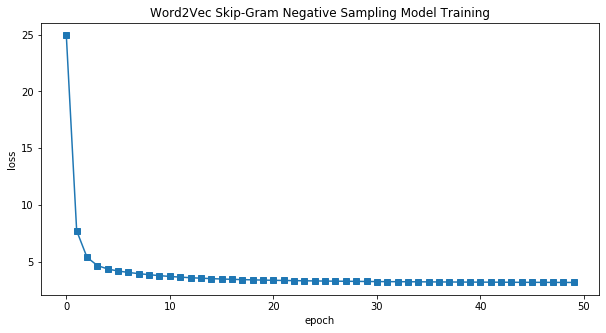

In [127]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.plot(loss_list, marker='s')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Word2Vec Skip-Gram Negative Sampling Model Training')
plt.show()

# 相似词寻找

我们利用word2vec词向量来探究相似词。

In [0]:
def get_similar_k(word, k, embed):
    W = (embed[1].weight.data + embed[0].weight.data) * 0.5
    x = W[word_to_idx[word]]
    cos = torch.matmul(W, x) / (torch.sum(W * W, dim=-1) * torch.sum(x * x) + 1e-9).sqrt()
    _, topk = torch.topk(cos, k=k+1)
    topk = topk.cpu().numpy()
    for i in topk[1:]:
        print(f"cosine similarity={cos[i]:.3f}: {idx_to_word[i]}.")

In [131]:
get_similar_k('woman', 4, (net[0], net[1]))

cosine similarity=0.411: her.
cosine similarity=0.404: mother.
cosine similarity=0.395: women.
cosine similarity=0.388: pregnant.
